# Large scale learning with kernels

1. [Imports](#imports)
2. [Random Fourier Features](#rff)
3. [Nÿstrom](#nÿstrom)
3. [Experiments on synthetic data](#synthetic)
    1. [Performance with D](#synt_D)
    2. [Influence of the regularization](#synt_reg)
4. [Experiments on the CT Slices dataset](#CT)
    1. [Performance with D](#CT_D)
    2. [Influence of the regularization](#CT_reg)

## Imports <a name="imports"></a>

In [124]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR, SVC, LinearSVC
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from time import time
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

DATA = {
    "YearPredictionMSD.txt.zip": "1R3CXYssjftxi7HIXXgeWCAZh65ByEumt",
    "slice_localization_data.zip": "1ZJamggugQuj-sE1EFWfghhR3dEY2K9Ib",
}

for file_name, file_id in DATA.items():
    output_file = os.path.join('data', file_name)
    gdd.download_file_from_google_drive(file_id=file_id, dest_path=output_file)

## Random Fourier Features <a name="rff"></a>

In [3]:
from rkhs.rff import RFF

## Nyström <a name="nÿstrom"></a>

In [55]:
from rkhs.nystrom import PlainNystromRegressor, SGDPlainNystromRegressor, SGDPlainNystromClassifier

## Experiments on synthetic data: classification <a name="synthetic"></a>

In [56]:
X, y = make_classification(n_samples=50000, n_features=120, n_informative=15, n_classes=2, random_state=17)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [58]:
score_lin = float(np.loadtxt('synthetic_clf_results/score_lin.csv', delimiter=',',skiprows=0))
score_train_lin = float(np.loadtxt('synthetic_clf_results/score_train_lin.csv', delimiter=',',skiprows=0))
time_lin = float(np.loadtxt('synthetic_clf_results/time_lin.csv', delimiter=',',skiprows=0))
score_gauss = float(np.loadtxt('synthetic_clf_results/score_gauss.csv', delimiter=',',skiprows=0))
score_train_gauss = float(np.loadtxt('synthetic_clf_results/score_train_gauss.csv', delimiter=',',skiprows=0))
time_gauss = float(np.loadtxt('synthetic_clf_results/time_gauss.csv', delimiter=',',skiprows=0))

In [154]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVC', LinearSVC(dual=False)),])

t0 = time()
lin.fit(X_train, y_train)
time_lin = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
score_train_lin = accuracy_score(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
score_lin = accuracy_score(y_test, y_pred_lin)

In [155]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVC', SVC(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
score_train_gauss = accuracy_score(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
score_gauss = accuracy_score(y_test, y_pred_gauss)

In [157]:
np.savetxt('synthetic_clf_results/score_lin.csv', np.asarray([score_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/score_train_lin.csv', np.asarray([score_train_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/time_lin.csv', np.asarray([time_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/score_gauss.csv', np.asarray([score_gauss]), delimiter=',')
np.savetxt('synthetic_clf_results/score_train_gauss.csv', np.asarray([score_train_gauss]), delimiter=',')
np.savetxt('synthetic_clf_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

### Performance with D <a name="synt_D"></a>

In [59]:
scores_rff = np.loadtxt('synthetic_clf_results/scores_rff.csv', delimiter=',',skiprows=0)
scores_train_rff = np.loadtxt('synthetic_clf_results/scores_train_rff.csv', delimiter=',',skiprows=0)
times_rff = np.loadtxt('synthetic_clf_results/times_rff.csv', delimiter=',',skiprows=0)
list_D = np.loadtxt('synthetic_clf_results/list_D.csv', delimiter=',',skiprows=0)

In [158]:
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
M = 10
scores_rff = np.empty((nD,M))
scores_train_rff = np.empty((nD,M))
times_rff = np.empty((nD,M))

for i,D in enumerate(tqdm(list_D)):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = D)),
                        ('LinearSVC', LinearSVC(dual=False)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff[i,j] = time() - t0
        
        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff[i,j] = accuracy_score(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff[i,j] = accuracy_score(y_test, y_pred_rff)

In [159]:
np.savetxt('synthetic_clf_results/scores_rff.csv', scores_rff, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_rff.csv', scores_train_rff, delimiter=',')
np.savetxt('synthetic_clf_results/times_rff.csv', times_rff, delimiter=',')
np.savetxt('synthetic_clf_results/list_D.csv', list_D, delimiter=',')

In [61]:
scores_nys = np.empty((nD,M))
scores_train_nys = np.empty((nD,M))
times_nys = np.empty((nD,M))

for i,D in enumerate(tqdm(list_D)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('Nystrom', SGDPlainNystromClassifier(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys[i,j] = accuracy_score(y_test, y_pred_nys)

100%|██████████| 10/10 [12:52<00:00, 77.28s/it] 


In [68]:
np.savetxt('synthetic_clf_results/scores_nys.csv', scores_nys, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys.csv', scores_train_nys, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys.csv', times_nys, delimiter=',')

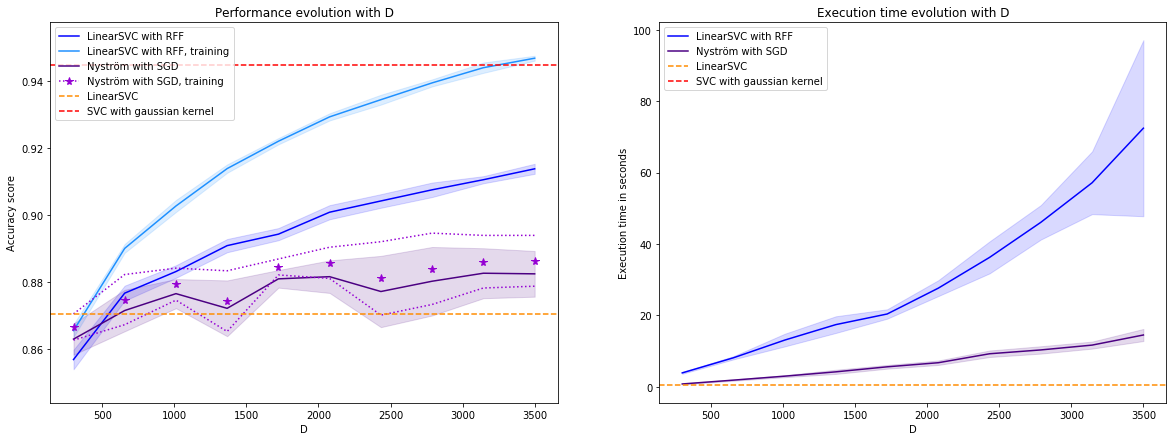

In [76]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1)),
            max(np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1)),
            max(np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1)),
            max(np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)+0.01
y_min = min(min(np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1)),
            min(np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1)),
            min(np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1)),
            min(np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_rff, axis=1), '-', color='blue', label='LinearSVC with RFF')
ax1.fill_between(list_D, np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1),
                 np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_rff, axis=1), '-', color='dodgerblue', label='LinearSVC with RFF, training')
ax1.fill_between(list_D, np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1),
                 np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1), 
                 color='dodgerblue', alpha=0.15)

ax1.plot(list_D, np.mean(scores_nys, axis=1), '-', color='indigo', label='Nyström with SGD')
ax1.fill_between(list_D, np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1),
                 np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1), 
                 color='indigo', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys, axis=1), '*', markersize=8, color='darkviolet',label='Nyström with SGD, training')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1), ':',color='darkviolet')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1), ':',color='darkviolet')


ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Accuracy score")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[3].set_linestyle(':')
ax1.legend(loc='upper left', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff, axis=1) + np.std(times_rff, axis=1)),
            max(np.mean(times_nys, axis=1) + np.std(times_nys, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_rff, axis=1) - np.std(times_rff, axis=1)),
            min(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_rff, axis=1), '-', color='blue', label='LinearSVC with RFF')
ax2.fill_between(list_D, np.mean(times_rff, axis=1) - np.std(times_rff, axis=1),
                 np.mean(times_rff, axis=1) + np.std(times_rff, axis=1), 
                 color='blue', alpha=0.15)
                 
ax2.plot(list_D, np.mean(times_nys, axis=1), '-', color='indigo', label='Nyström with SGD')
ax2.fill_between(list_D, np.mean(times_nys, axis=1) - np.std(times_nys, axis=1),
                 np.mean(times_nys, axis=1) + np.std(times_nys, axis=1), 
                 color='indigo', alpha=0.15)

                 
ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("D_influence_synthetic_clf")

plt.show()

In [11]:
print("SVC with gaussian kernel execution time:", time_gauss)

SVC with gaussian kernel execution time: 242.52361536026


### Influence of the regularization  <a name="synt_reg"></a>

In [77]:
scores_rff_h = np.loadtxt('synthetic_clf_results/scores_rff_h.csv', delimiter=',',skiprows=0)
scores_train_rff_h = np.loadtxt('synthetic_clf_results/scores_train_rff_h.csv', delimiter=',',skiprows=0)
times_rff_h = np.loadtxt('synthetic_clf_results/times_rff_h.csv', delimiter=',',skiprows=0)
scores_rff_sh = np.loadtxt('synthetic_clf_results/scores_rff_sh.csv', delimiter=',',skiprows=0)
scores_train_rff_sh = np.loadtxt('synthetic_clf_results/scores_train_rff_sh.csv', delimiter=',',skiprows=0)
times_rff_sh = np.loadtxt('synthetic_clf_results/times_rff_sh.csv', delimiter=',',skiprows=0)
list_C = np.loadtxt('synthetic_clf_results/list_C.csv', delimiter=',',skiprows=0)

In [78]:
nC = 8
list_C = np.linspace(0.01,2,nC)
M = 10

In [98]:
scores_rff_h = np.empty((nC,M))
scores_train_rff_h = np.empty((nC,M))
times_rff_h = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2500)),
                        ('LinearSVC', LinearSVC(C = C, loss='hinge')),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_h[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_h[i,j] = accuracy_score(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_h[i,j] = accuracy_score(y_test, y_pred_rff)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [02:22<16:39, 142.73s/it]

 25%|██▌       | 2/8 [07:31<19:15, 192.59s/it]

 38%|███▊      | 3/8 [13:21<19:58, 239.76s/it]

 50%|█████     | 4/8 [19:28<18:31, 277.86s/it]

 62%|██████▎   | 5/8 [23:41<13:31, 270.59s/it]

 75%|███████▌  | 6/8 [29:06<09:33, 286.79s/it]

 88%|████████▊ | 7/8 [34:09<04:51, 291.73s/it]

100%|██████████| 8/8 [38:46<00:00, 290.86s/it]


In [99]:
scores_rff_sh = np.empty((nC,M))
scores_train_rff_sh = np.empty((nC,M))
times_rff_sh = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2500)),
                        ('LinearSVC', LinearSVC(dual=False, C = C)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_sh[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_sh[i,j] = accuracy_score(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_sh[i,j] = accuracy_score(y_test, y_pred_rff)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [03:01<21:08, 181.27s/it]

 25%|██▌       | 2/8 [08:05<21:49, 218.29s/it]

 38%|███▊      | 3/8 [13:32<20:53, 250.65s/it]

 50%|█████     | 4/8 [19:06<18:23, 275.81s/it]

 62%|██████▎   | 5/8 [24:54<14:51, 297.31s/it]

 75%|███████▌  | 6/8 [30:51<10:30, 315.40s/it]

 88%|████████▊ | 7/8 [36:50<05:28, 328.44s/it]

100%|██████████| 8/8 [43:00<00:00, 322.56s/it]


In [100]:
np.savetxt('synthetic_clf_results/scores_rff_h.csv', scores_rff_h, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_rff_h.csv', scores_train_rff_h, delimiter=',')
np.savetxt('synthetic_clf_results/times_rff_h.csv', times_rff_h, delimiter=',')
np.savetxt('synthetic_clf_results/scores_rff_sh.csv', scores_rff_sh, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_rff_sh.csv', scores_train_rff_sh, delimiter=',')
np.savetxt('synthetic_clf_results/times_rff_sh.csv', times_rff_sh, delimiter=',')
np.savetxt('synthetic_clf_results/list_C.csv', list_C, delimiter=',')

In [79]:
scores_nys_h = np.empty((nC,M))
scores_train_nys_h = np.empty((nC,M))
times_nys_h = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=3000, lambda_reg=C, loss='hinge')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_h[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_h[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_h[i,j] = accuracy_score(y_test, y_pred_nys)

100%|██████████| 8/8 [17:27<00:00, 130.96s/it]


In [81]:
np.savetxt('synthetic_clf_results/scores_nys_h.csv', scores_nys_h, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_h.csv', scores_train_nys_h, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_h.csv', times_nys_h, delimiter=',')

In [83]:
scores_nys_sh = np.empty((nC,M))
scores_train_nys_sh = np.empty((nC,M))
times_nys_sh = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=3000, lambda_reg=C, loss='squared_hinge')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_sh[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_sh[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_sh[i,j] = accuracy_score(y_test, y_pred_nys)


  0%|          | 0/8 [00:00<?, ?it/s]/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


KeyboardInterrupt: 

In [92]:
np.savetxt('synthetic_clf_results/scores_nys_sh.csv', scores_nys_sh, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_sh.csv', scores_train_nys_sh, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_sh.csv', times_nys_sh, delimiter=',')

In [93]:
scores_lin = np.empty((nC,1))
scores_train_lin = np.empty((nC,1))
times_lin = np.empty((nC,1))

for i,C in enumerate(tqdm(list_C)):
    lin = Pipeline([('Scaler',StandardScaler()),
                    ('LinearSVC', LinearSVC(dual=False, C=C)),])

    t0 = time()
    lin.fit(X_train, y_train)
    times_lin[i] = time() - t0

    y_pred_train_lin = lin.predict(X_train)                      
    scores_train_lin[i] = accuracy_score(y_train, y_pred_train_lin)

    y_pred_lin = lin.predict(X_test)                      
    scores_lin[i] = accuracy_score(y_test, y_pred_lin)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:04,  1.58it/s]

 25%|██▌       | 2/8 [00:01<00:03,  1.67it/s]

 38%|███▊      | 3/8 [00:01<00:02,  1.78it/s]

 50%|█████     | 4/8 [00:02<00:02,  1.89it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.98it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.06it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.11it/s]

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


In [94]:
np.savetxt('synthetic_clf_results/scores_lin.csv', scores_lin, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_lin.csv', scores_train_lin, delimiter=',')
np.savetxt('synthetic_clf_results/times_lin.csv', times_lin, delimiter=',')

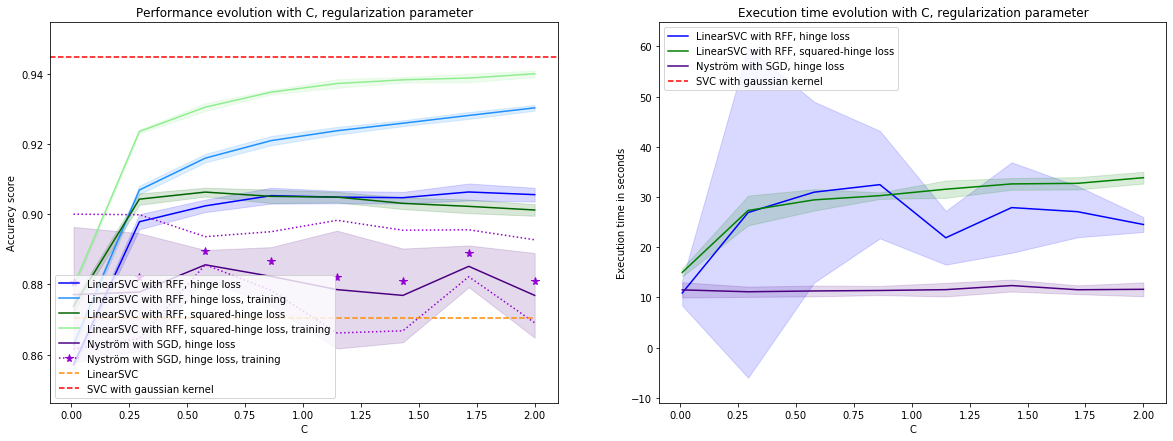

In [101]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff_h, axis=1) + np.std(scores_rff_h, axis=1)),
            max(np.mean(scores_train_rff_h, axis=1) + np.std(scores_train_rff_h, axis=1)),
            max(np.mean(scores_rff_sh, axis=1) + np.std(scores_rff_sh, axis=1)),
            max(np.mean(scores_train_rff_sh, axis=1) + np.std(scores_train_rff_sh, axis=1)),
            max(np.mean(scores_nys_h, axis=1) + np.std(scores_nys_h, axis=1)),
            max(np.mean(scores_train_nys_h, axis=1) + np.std(scores_train_nys_h, axis=1)),
            float(max(scores_lin)), score_gauss)+0.01
y_min = min(min(np.mean(scores_rff_h, axis=1) - np.std(scores_rff_h, axis=1)),
            min(np.mean(scores_train_rff_h, axis=1) - np.std(scores_train_rff_h, axis=1)),
            min(np.mean(scores_rff_sh, axis=1) - np.std(scores_rff_sh, axis=1)),
            min(np.mean(scores_train_rff_sh, axis=1) - np.std(scores_train_rff_sh, axis=1)),
            min(np.mean(scores_nys_h, axis=1) - np.std(scores_nys_h, axis=1)),
            min(np.mean(scores_train_nys_h, axis=1) - np.std(scores_train_nys_h, axis=1)),
            float(min(scores_lin)), score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_rff_h, axis=1), '-', color='blue', label='LinearSVC with RFF, hinge loss')
ax1.fill_between(list_C, np.mean(scores_rff_h, axis=1) - np.std(scores_rff_h, axis=1),
                 np.mean(scores_rff_h, axis=1) + np.std(scores_rff_h, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_rff_h, axis=1), '-', color='dodgerblue', label='LinearSVC with RFF, hinge loss, training')
ax1.fill_between(list_C, np.mean(scores_train_rff_h, axis=1) - np.std(scores_train_rff_h, axis=1),
                 np.mean(scores_train_rff_h, axis=1) + np.std(scores_train_rff_h, axis=1), 
                 color='dodgerblue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_rff_sh, axis=1), '-', color='darkgreen', label='LinearSVC with RFF, squared-hinge loss')
ax1.fill_between(list_C, np.mean(scores_rff_sh, axis=1) - np.std(scores_rff_sh, axis=1),
                 np.mean(scores_rff_sh, axis=1) + np.std(scores_rff_sh, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_rff_sh, axis=1), '-', color='lightgreen', label='LinearSVC with RFF, squared-hinge loss, training')
ax1.fill_between(list_C, np.mean(scores_train_rff_sh, axis=1) - np.std(scores_train_rff_sh, axis=1),
                 np.mean(scores_train_rff_sh, axis=1) + np.std(scores_train_rff_sh, axis=1), 
                 color='lightgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_nys_h, axis=1), '-', color='indigo', label='Nyström with SGD, hinge loss')
ax1.fill_between(list_C, np.mean(scores_nys_h, axis=1) - np.std(scores_nys_h, axis=1),
                 np.mean(scores_nys_h, axis=1) + np.std(scores_nys_h, axis=1), 
                 color='indigo', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_h, axis=1), '*', markersize=8, color='darkviolet',label='Nyström with SGD, hinge loss, training')
ax1.plot(list_C, np.mean(scores_train_nys_h, axis=1) - np.std(scores_train_nys_h, axis=1), ':',color='darkviolet')
ax1.plot(list_C, np.mean(scores_train_nys_h, axis=1) + np.std(scores_train_nys_h, axis=1), ':',color='darkviolet')

ax1.plot(list_C, scores_lin, color='darkorange', linestyle='--', label='LinearSVC')

ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy score")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[5].set_linestyle(':')
ax1.legend(loc='lower left', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff_h, axis=1) + np.std(times_rff_h, axis=1)),
            max(np.mean(times_rff_sh, axis=1) + np.std(times_rff_sh, axis=1)),
            max(np.mean(times_nys_h, axis=1) + np.std(times_nys_h, axis=1)),
            float(max(times_lin)))+5
y_min = min(min(np.mean(times_rff_h, axis=1) - np.std(times_rff_h, axis=1)),
            min(np.mean(times_rff_sh, axis=1) - np.std(times_rff_sh, axis=1)),
            min(np.mean(times_nys_h, axis=1) - np.std(times_nys_h, axis=1)),
            float(min(times_lin)))-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_rff_h, axis=1), '-', color='blue', label='LinearSVC with RFF, hinge loss')
ax2.fill_between(list_C, np.mean(times_rff_h, axis=1) - np.std(times_rff_h, axis=1),
                 np.mean(times_rff_h, axis=1) + np.std(times_rff_h, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_rff_sh, axis=1), '-', color='green', label='LinearSVC with RFF, squared-hinge loss')
ax2.fill_between(list_C, np.mean(times_rff_sh, axis=1) - np.std(times_rff_sh, axis=1),
                 np.mean(times_rff_sh, axis=1) + np.std(times_rff_sh, axis=1), 
                 color='green', alpha=0.15)

ax2.plot(list_C, np.mean(times_nys_h, axis=1), '-', color='indigo', label='Nyström with SGD, hinge loss')
ax2.fill_between(list_C, np.mean(times_nys_h, axis=1) - np.std(times_nys_h, axis=1),
                 np.mean(times_nys_h, axis=1) + np.std(times_nys_h, axis=1), 
                 color='indigo', alpha=0.15)

ax1.plot(list_C, times_lin, color='darkorange', linestyle='--', label='LinearSVC')

ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_loss_influence_synthetic_clf.png")
plt.show()

In [172]:
print("SVC with gaussian kernel execution time:", time_gauss)

SVC with gaussian kernel execution time: 242.52361536026


In [102]:
scores_rff_l1 = np.loadtxt('synthetic_clf_results/scores_rff_l1.csv', delimiter=',',skiprows=0)
scores_train_rff_l1 = np.loadtxt('synthetic_clf_results/scores_train_rff_l1.csv', delimiter=',',skiprows=0)
times_rff_l1 = np.loadtxt('synthetic_clf_results/times_rff_l1.csv', delimiter=',',skiprows=0)
scores_rff_l2 = np.loadtxt('synthetic_clf_results/scores_rff_l2.csv', delimiter=',',skiprows=0)
scores_train_rff_l2 = np.loadtxt('synthetic_clf_results/scores_train_rff_l2.csv', delimiter=',',skiprows=0)
times_rff_l2 = np.loadtxt('synthetic_clf_results/times_rff_l2.csv', delimiter=',',skiprows=0)

In [177]:
scores_rff_l1 = np.empty((nC,M))
scores_train_rff_l1 = np.empty((nC,M))
times_rff_l1 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2500)),
                        ('LinearSVC', LinearSVC(dual=False, C = C, penalty='l1')),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l1[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_l1[i,j] = accuracy_score(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_l1[i,j] = accuracy_score(y_test, y_pred_rff)

/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

KeyboardInterrupt: 

In [198]:
scores_rff_l2 = scores_rff_h
scores_train_rff_l2 = scores_train_rff_h
times_rff_l2 = times_rff_h

In [200]:
np.savetxt('synthetic_clf_results/scores_rff_l1.csv', scores_rff_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_rff_l1.csv', scores_train_rff_l1, delimiter=',')
np.savetxt('synthetic_clf_results/times_rff_l1.csv', times_rff_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_rff_l2.csv', scores_rff_l2, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_rff_l2.csv', scores_train_rff_l2, delimiter=',')
np.savetxt('synthetic_clf_results/times_rff_l2.csv', times_rff_l2, delimiter=',')

In [103]:
scores_nys_l2 = scores_nys_h
scores_train_nys_l2 = scores_train_nys_h
times_nys_l2 = times_nys_h

In [104]:
scores_nys_l1 = np.empty((nC,M))
scores_train_nys_l1 = np.empty((nC,M))
times_nys_l1 = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=3000, lambda_reg=C, loss='hinge', penalty='l1')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_h[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l1[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l1[i,j] = accuracy_score(y_test, y_pred_nys)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [03:28<24:22, 208.92s/it]

 25%|██▌       | 2/8 [06:56<20:50, 208.46s/it]

 38%|███▊      | 3/8 [10:23<17:19, 207.97s/it]

 50%|█████     | 4/8 [13:50<13:51, 207.86s/it]

 62%|██████▎   | 5/8 [17:17<10:22, 207.53s/it]

 75%|███████▌  | 6/8 [20:56<07:01, 210.91s/it]

 88%|████████▊ | 7/8 [24:34<03:33, 213.05s/it]

100%|██████████| 8/8 [28:09<00:00, 211.13s/it]


In [105]:
np.savetxt('synthetic_clf_results/scores_nys_l1.csv', scores_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_l1.csv', scores_train_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_l1.csv', times_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_nys_l2.csv', scores_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_l2.csv', scores_train_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_l2.csv', times_nys_l2, delimiter=',')

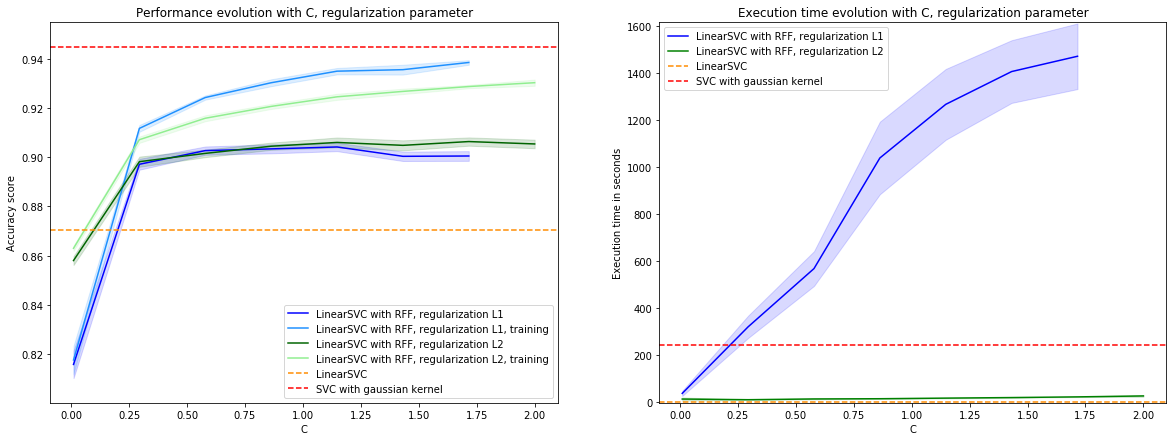

In [199]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff_l1[0:7], axis=1) + np.std(scores_rff_l1[0:7], axis=1)),
            max(np.mean(scores_train_rff_l1[0:7], axis=1) + np.std(scores_train_rff_l1[0:7], axis=1)),
            max(np.mean(scores_rff_l2, axis=1) + np.std(scores_rff_l2, axis=1)),
            max(np.mean(scores_train_rff_l2, axis=1) + np.std(scores_train_rff_l2, axis=1)),
            score_lin, score_gauss)+0.01
y_min = min(min(np.mean(scores_rff_l1[0:7], axis=1) - np.std(scores_rff_l1[0:7], axis=1)),
            min(np.mean(scores_train_rff_l1[0:7], axis=1) - np.std(scores_train_rff_l1[0:7], axis=1)),
            min(np.mean(scores_rff_l2, axis=1) - np.std(scores_rff_l2, axis=1)),
            min(np.mean(scores_train_rff_l2, axis=1) - np.std(scores_train_rff_l2, axis=1)),
            score_lin, score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C[0:7], np.mean(scores_rff_l1[0:7], axis=1), '-', color='blue', label='LinearSVC with RFF, regularization L1')
ax1.fill_between(list_C[0:7], np.mean(scores_rff_l1[0:7], axis=1) - np.std(scores_rff_l1[0:7], axis=1),
                 np.mean(scores_rff_l1[0:7], axis=1) + np.std(scores_rff_l1[0:7], axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C[0:7], np.mean(scores_train_rff_l1[0:7], axis=1), '-', color='dodgerblue', label='LinearSVC with RFF, regularization L1, training')
ax1.fill_between(list_C[0:7], np.mean(scores_train_rff_l1[0:7], axis=1) - np.std(scores_train_rff_l1[0:7], axis=1),
                 np.mean(scores_train_rff_l1[0:7], axis=1) + np.std(scores_train_rff_l1[0:7], axis=1), 
                 color='dodgerblue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_rff_l2, axis=1), '-', color='darkgreen', label='LinearSVC with RFF, regularization L2')
ax1.fill_between(list_C, np.mean(scores_rff_l2, axis=1) - np.std(scores_rff_l2, axis=1),
                 np.mean(scores_rff_l2, axis=1) + np.std(scores_rff_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_rff_l2, axis=1), '-', color='lightgreen', label='LinearSVC with RFF, regularization L2, training')
ax1.fill_between(list_C, np.mean(scores_train_rff_l2, axis=1) - np.std(scores_train_rff_l2, axis=1),
                 np.mean(scores_train_rff_l2, axis=1) + np.std(scores_train_rff_l2, axis=1), 
                 color='lightgreen', alpha=0.15)

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy score")

ax1.legend(loc='lower right')

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff_l1[0:7], axis=1) + np.std(times_rff_l1[0:7], axis=1)),
            max(np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_rff_l1[0:7], axis=1) - np.std(times_rff_l1[0:7], axis=1)),
            min(np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C[0:7], np.mean(times_rff_l1[0:7], axis=1), '-', color='blue', label='LinearSVC with RFF, regularization L1')
ax2.fill_between(list_C[0:7], np.mean(times_rff_l1[0:7], axis=1) - np.std(times_rff_l1[0:7], axis=1),
                 np.mean(times_rff_l1[0:7], axis=1) + np.std(times_rff_l1[0:7], axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_rff_l2, axis=1), '-', color='green', label='LinearSVC with RFF, regularization L2')
ax2.fill_between(list_C, np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1),
                 np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_synthetic_clf.png")
plt.show()

## Experiments on the CT Slices dataset <a name="CT"></a>

In [132]:
data = pd.read_csv('data/slice_localization_data.zip')

In [133]:
data.shape

(53500, 386)

In [134]:
features = data.drop('reference', axis=1)

In [135]:
y = data.loc[:,'reference']

In [136]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=24)
X_train = X_train.values
X_test = X_test.values

In [111]:
score_lin = float(np.loadtxt('CT_results/score_lin.csv', delimiter=',',skiprows=0))
score_train_lin = float(np.loadtxt('CT_results/score_train_lin.csv', delimiter=',',skiprows=0))
time_lin = float(np.loadtxt('CT_results/time_lin.csv', delimiter=',',skiprows=0))
score_gauss = float(np.loadtxt('CT_results/score_gauss.csv', delimiter=',',skiprows=0))
score_train_gauss = float(np.loadtxt('CT_results/score_train_gauss.csv', delimiter=',',skiprows=0))
time_gauss = float(np.loadtxt('CT_results/time_gauss.csv', delimiter=',',skiprows=0))

In [140]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVR', LinearSVR(max_iter=10000)),])

t0 = time()
lin.fit(X_train, y_train)
time_lin_l1 = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
mse_train_lin_l1 = mean_squared_error(y_train, y_pred_train_lin)
mae_train_lin_l1 = mean_absolute_error(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
mse_lin_l1 = mean_squared_error(y_test, y_pred_lin)
mae_lin_l1 = mean_absolute_error(y_test, y_pred_lin)

In [141]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVR', LinearSVR(max_iter=10000, loss='squared_epsilon_insensitive')),])

t0 = time()
lin.fit(X_train, y_train)
time_lin_l2 = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
mse_train_lin_l2 = mean_squared_error(y_train, y_pred_train_lin)
mae_train_lin_l2 = mean_absolute_error(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
mse_lin_l2 = mean_squared_error(y_test, y_pred_lin)
mae_lin_l2 = mean_absolute_error(y_test, y_pred_lin)

/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [151]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVR', SVR(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
mse_train_gauss = mean_squared_error(y_train, y_pred_train_gauss)
mae_train_gauss = mean_absolute_error(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
mse_gauss = mean_squared_error(y_test, y_pred_gauss)
mae_gauss = mean_absolute_error(y_test, y_pred_gauss)

In [152]:
np.savetxt('CT_results/mse_lin_l1.csv', np.asarray([mse_lin_l1]), delimiter=',')
np.savetxt('CT_results/mse_train_lin_l1.csv', np.asarray([mse_train_lin_l1]), delimiter=',')
np.savetxt('CT_results/mae_lin_l1.csv', np.asarray([mae_lin_l1]), delimiter=',')
np.savetxt('CT_results/mae_train_lin_l1.csv', np.asarray([mae_train_lin_l1]), delimiter=',')
np.savetxt('CT_results/time_lin_l1.csv', np.asarray([time_lin_l1]), delimiter=',')
np.savetxt('CT_results/mse_lin_l2.csv', np.asarray([mse_lin_l2]), delimiter=',')
np.savetxt('CT_results/mse_train_lin_l2.csv', np.asarray([mse_train_lin_l2]), delimiter=',')
np.savetxt('CT_results/mae_lin_l2.csv', np.asarray([mae_lin_l2]), delimiter=',')
np.savetxt('CT_results/mae_train_lin_l2.csv', np.asarray([mae_train_lin_l2]), delimiter=',')
np.savetxt('CT_results/time_lin_l2.csv', np.asarray([time_lin_l2]), delimiter=',')
np.savetxt('CT_results/mse_gauss.csv', np.asarray([mse_gauss]), delimiter=',')
np.savetxt('CT_results/mse_train_gauss.csv', np.asarray([mse_train_gauss]), delimiter=',')
np.savetxt('CT_results/mae_gauss.csv', np.asarray([mae_gauss]), delimiter=',')
np.savetxt('CT_results/mae_train_gauss.csv', np.asarray([mae_train_gauss]), delimiter=',')
np.savetxt('CT_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

### Performance with D <a name="CT_D"></a>

In [113]:
mse_rff = np.loadtxt('CT_results/mse_rff.csv', delimiter=',',skiprows=0)
mse_train_rff = np.loadtxt('CT_results/mse_train_rff.csv', delimiter=',',skiprows=0)
times_rff = np.loadtxt('CT_results/times_rff.csv', delimiter=',',skiprows=0)

In [153]:
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
nb_iter = 5

In [154]:
mse_rff_l1 = np.empty((nD,nb_iter))
mse_train_rff_l1 = np.empty((nD,nb_iter))
mae_rff_l1 = np.empty((nD,nb_iter))
mae_train_rff_l1 = np.empty((nD,nb_iter))
times_rff_l1 = np.empty((nD,nb_iter))

for i,D in enumerate(tqdm(list_D)):
    for j in range(nb_iter):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = D)),
                        ('LinearSVR', LinearSVR(max_iter=10000)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l1[i,j] = time() - t0
        
        y_pred_train_rff = rff.predict(X_train)                      
        mse_train_rff_l1[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        mae_train_rff_l1[i,j] = mean_absolute_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        mse_rff_l1[i,j] = mean_squared_error(y_test, y_pred_rff)
        mae_rff_l1[i,j] = mean_absolute_error(y_test, y_pred_rff)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:16<02:30, 16.72s/it]

 20%|██        | 2/10 [00:45<02:42, 20.27s/it]

 30%|███       | 3/10 [01:20<02:53, 24.79s/it]

 40%|████      | 4/10 [02:11<03:16, 32.73s/it]

 50%|█████     | 5/10 [03:10<03:22, 40.56s/it]

 60%|██████    | 6/10 [04:21<03:18, 49.65s/it]

 70%|███████   | 7/10 [05:54<03:08, 62.73s/it]

 80%|████████  | 8/10 [08:54<03:15, 97.78s/it]

 90%|█████████ | 9/10 [12:22<02:10, 130.78s/it]

100%|██████████| 10/10 [35:42<00:00, 214.22s/it]


In [155]:
np.savetxt('CT_results/mse_rff_l1.csv', mse_rff_l1, delimiter=',')
np.savetxt('CT_results/mse_train_rff_l1.csv', mse_train_rff_l1, delimiter=',')
np.savetxt('CT_results/mae_rff_l1.csv', mae_rff_l1, delimiter=',')
np.savetxt('CT_results/mae_train_rff_l1.csv', mae_train_rff_l1, delimiter=',')
np.savetxt('CT_results/times_rff_l1.csv', times_rff_l1, delimiter=',')
np.savetxt('CT_results/list_D.csv', list_D, delimiter=',')

In [156]:
mse_rff_l2 = np.empty((nD,nb_iter))
mse_train_rff_l2 = np.empty((nD,nb_iter))
mae_rff_l2 = np.empty((nD,nb_iter))
mae_train_rff_l2 = np.empty((nD,nb_iter))
times_rff_l2 = np.empty((nD,nb_iter))

for i,D in enumerate(tqdm(list_D)):
    for j in range(nb_iter):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = D)),
                        ('LinearSVR', LinearSVR(max_iter=10000, loss='squared_epsilon_insensitive')),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l2[i,j] = time() - t0
        
        y_pred_train_rff = rff.predict(X_train)                      
        mse_train_rff_l2[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        mae_train_rff_l2[i,j] = mean_absolute_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        mse_rff_l2[i,j] = mean_squared_error(y_test, y_pred_rff)
        mae_rff_l2[i,j] = mean_absolute_error(y_test, y_pred_rff)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:28<04:14, 28.23s/it]

 20%|██        | 2/10 [01:17<04:37, 34.68s/it]

 30%|███       | 3/10 [02:32<05:26, 46.65s/it]

 40%|████      | 4/10 [04:06<06:05, 60.93s/it]

 50%|█████     | 5/10 [06:23<06:58, 83.66s/it]

 60%|██████    | 6/10 [08:47<06:47, 101.91s/it]

 70%|███████   | 7/10 [11:55<06:22, 127.61s/it]

 80%|████████  | 8/10 [32:16<15:11, 455.72s/it]

 90%|█████████ | 9/10 [48:14<10:06, 606.21s/it]

100%|██████████| 10/10 [2:15:59<00:00, 815.98s/it] 


In [157]:
np.savetxt('CT_results/mse_rff_l2.csv', mse_rff_l2, delimiter=',')
np.savetxt('CT_results/mse_train_rff_l2.csv', mse_train_rff_l2, delimiter=',')
np.savetxt('CT_results/mae_rff_l2.csv', mae_rff_l2, delimiter=',')
np.savetxt('CT_results/mae_train_rff_l2.csv', mae_train_rff_l2, delimiter=',')
np.savetxt('CT_results/times_rff_l2.csv', times_rff_l2, delimiter=',')
np.savetxt('CT_results/list_D.csv', list_D, delimiter=',')

In [114]:
scores_nys = np.empty((nD,nb_iter))
scores_train_nys = np.empty((nD,nb_iter))
times_nys = np.empty((nD,nb_iter))

for i,D in enumerate(tqdm(list_D)):
    for j in range(nb_iter):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys[i,j] = mean_squared_error(y_test, y_pred_nys)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:19<47:54, 319.36s/it]

 20%|██        | 2/10 [13:41<49:53, 374.16s/it]

 30%|███       | 3/10 [26:12<56:51, 487.38s/it]

 40%|████      | 4/10 [40:36<1:00:01, 600.30s/it]

 50%|█████     | 5/10 [57:35<1:00:29, 725.90s/it]

 60%|██████    | 6/10 [1:15:52<55:48, 837.15s/it]

 70%|███████   | 7/10 [1:34:59<46:30, 930.21s/it]

 80%|████████  | 8/10 [1:57:01<34:55, 1047.62s/it]

 90%|█████████ | 9/10 [2:23:43<20:13, 1213.85s/it]

100%|██████████| 10/10 [2:49:30<00:00, 1017.08s/it]


In [115]:
np.savetxt('CT_results/scores_nys.csv', scores_nys, delimiter=',')
np.savetxt('CT_results/scores_train_nys.csv', scores_train_nys, delimiter=',')
np.savetxt('CT_results/times_nys.csv', times_nys, delimiter=',')

In [158]:
mse_nys_plain = np.empty((nD,nb_iter))
mse_train_nys_plain = np.empty((nD,nb_iter))
mae_nys_plain = np.empty((nD,nb_iter))
mae_train_nys_plain = np.empty((nD,nb_iter))
times_nys_plain = np.empty((nD,nb_iter))

for i,D in enumerate(tqdm(list_D)):
    for j in range(nb_iter):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', PlainNystromRegressor(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_plain[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        mse_train_nys_plain[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        mae_train_nys_plain[i,j] = mean_absolute_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        mse_nys_plain[i,j] = mean_squared_error(y_test, y_pred_nys)
        mae_nys_plain[i,j] = mean_absolute_error(y_test, y_pred_nys)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:35,  3.99s/it]

 20%|██        | 2/10 [00:12<00:42,  5.26s/it]

 30%|███       | 3/10 [00:26<00:54,  7.83s/it]

 40%|████      | 4/10 [00:52<01:20, 13.35s/it]

 50%|█████     | 5/10 [01:27<01:39, 19.85s/it]

 60%|██████    | 6/10 [02:09<01:46, 26.68s/it]

 70%|███████   | 7/10 [03:07<01:48, 36.07s/it]

 80%|████████  | 8/10 [04:24<01:36, 48.13s/it]

 90%|█████████ | 9/10 [06:03<01:03, 63.36s/it]

100%|██████████| 10/10 [08:00<00:00, 48.10s/it]


In [159]:
np.savetxt('CT_results/mse_nys_plain.csv', mse_nys_plain, delimiter=',')
np.savetxt('CT_results/mse_train_nys_plain.csv', mse_train_nys_plain, delimiter=',')
np.savetxt('CT_results/mae_nys_plain.csv', mae_nys_plain, delimiter=',')
np.savetxt('CT_results/mae_train_nys_plain.csv', mae_train_nys_plain, delimiter=',')
np.savetxt('CT_results/times_nys_plain.csv', times_nys_plain, delimiter=',')

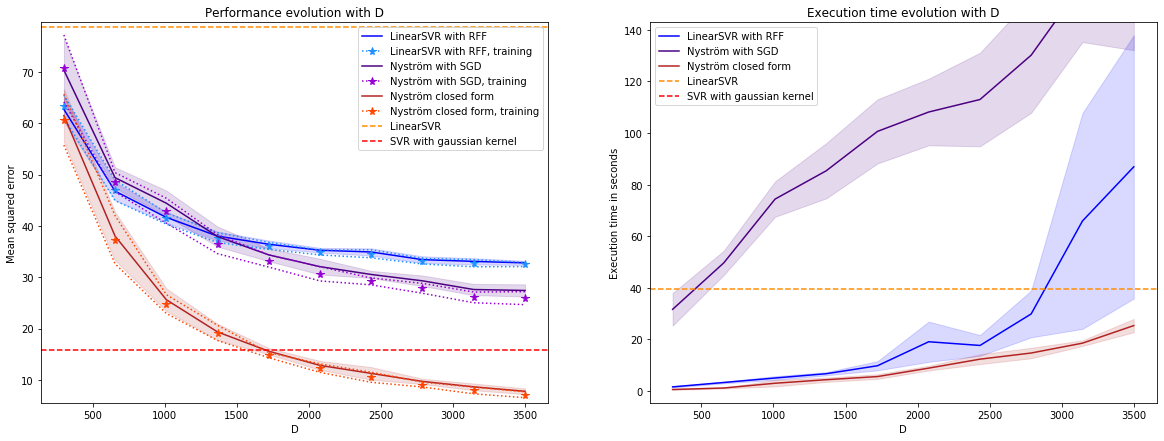

In [120]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1)),
            max(np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1)),
            max(np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1)),
            max(np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1)),
            max(np.mean(scores_nys_plain, axis=1) + np.std(scores_nys_plain, axis=1)),
            max(np.mean(scores_train_nys_plain, axis=1) + np.std(scores_train_nys_plain, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1)),
            min(np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1)),
            min(np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1)),
            min(np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1)),
            min(np.mean(scores_nys_plain, axis=1) - np.std(scores_nys_plain, axis=1)),
            min(np.mean(scores_train_nys_plain, axis=1) - np.std(scores_train_nys_plain, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_rff, axis=1), '-', color='blue', label='LinearSVR with RFF')
ax1.fill_between(list_D, np.mean(scores_rff, axis=1) - np.std(scores_rff, axis=1),
                 np.mean(scores_rff, axis=1) + np.std(scores_rff, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_rff, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with RFF, training')
ax1.plot(list_D, np.mean(scores_train_rff, axis=1) - np.std(scores_train_rff, axis=1), ':',color='dodgerblue')
ax1.plot(list_D, np.mean(scores_train_rff, axis=1) + np.std(scores_train_rff, axis=1), ':',color='dodgerblue')

ax1.plot(list_D, np.mean(scores_nys, axis=1), '-', color='indigo', label='Nyström with SGD')
ax1.fill_between(list_D, np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1),
                 np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1), 
                 color='indigo', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys, axis=1), '*', markersize=8, color='darkviolet',
         label='Nyström with SGD, training')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1), ':',color='darkviolet')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1), ':',color='darkviolet')

ax1.plot(list_D, np.mean(scores_nys_plain, axis=1), '-', color='firebrick', label='Nyström closed form')
ax1.fill_between(list_D, np.mean(scores_nys_plain, axis=1) - np.std(scores_nys_plain, axis=1),
                 np.mean(scores_nys_plain, axis=1) + np.std(scores_nys_plain, axis=1), 
                 color='firebrick', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys_plain, axis=1), '*', markersize=8, color='orangered',
         label='Nyström closed form, training')
ax1.plot(list_D, np.mean(scores_train_nys_plain, axis=1) - np.std(scores_train_nys_plain, axis=1), ':',color='orangered')
ax1.plot(list_D, np.mean(scores_train_nys_plain, axis=1) + np.std(scores_train_nys_plain, axis=1), ':',color='orangered')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
handles[5].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff, axis=1) + np.std(times_rff, axis=1)),
            max(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),
            max(np.mean(times_nys_plain, axis=1) - np.std(times_nys_plain, axis=1)),time_lin)+5
y_min = min(min(np.mean(times_rff, axis=1) - np.std(times_rff, axis=1)),
            min(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),
            min(np.mean(times_nys_plain, axis=1) - np.std(times_nys_plain, axis=1)),time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_rff, axis=1), '-', color='blue', label='LinearSVR with RFF')
ax2.fill_between(list_D, np.mean(times_rff, axis=1) - np.std(times_rff, axis=1),
                 np.mean(times_rff, axis=1) + np.std(times_rff, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_D, np.mean(times_nys, axis=1), '-', color='indigo', label='Nyström with SGD')
ax2.fill_between(list_D, np.mean(times_nys, axis=1) - np.std(times_nys, axis=1),
                 np.mean(times_nys, axis=1) + np.std(times_nys, axis=1), 
                 color='indigo', alpha=0.15)

ax2.plot(list_D, np.mean(times_nys_plain, axis=1), '-', color='firebrick', label='Nyström closed form')
ax2.fill_between(list_D, np.mean(times_nys_plain, axis=1) - np.std(times_nys_plain, axis=1),
                 np.mean(times_nys_plain, axis=1) + np.std(times_nys_plain, axis=1), 
                 color='firebrick', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("D_influence_CT")
plt.show()

In [40]:
print("SVR with gaussian kernel execution time:", time_gauss)

SVR with gaussian kernel execution time: 1274.2267017364502


### Influence of the regularization  <a name="CT_reg"></a>

In [121]:
eC_min = -6
eC_max = 1
list_C = [10**i for i in range(eC_min, eC_max+1)]
nC = eC_max-eC_min+1
M = 10

In [122]:
scores_rff_l1 = np.loadtxt('CT_results/scores_rff_l1.csv', delimiter=',',skiprows=0)
scores_train_rff_l1 = np.loadtxt('CT_results/scores_train_rff_l1.csv', delimiter=',',skiprows=0)
times_rff_l1 = np.loadtxt('CT_results/times_rff_l1.csv', delimiter=',',skiprows=0)
scores_rff_l2 = np.loadtxt('CT_results/scores_rff_l2.csv', delimiter=',',skiprows=0)
scores_train_rff_l2 = np.loadtxt('CT_results/scores_train_rff_l2.csv', delimiter=',',skiprows=0)
times_rff_l2 = np.loadtxt('CT_results/times_rff_l2.csv', delimiter=',',skiprows=0)
list_C = np.loadtxt('CT_results/list_C.csv', delimiter=',',skiprows=0)

In [42]:
scores_rff_l1 = np.empty((nC,M))
scores_train_rff_l1 = np.empty((nC,M))
times_rff_l1 = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2000)),
                        ('LinearSVR', LinearSVR(C = C, max_iter=10000)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l1[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_l1[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_l1[i,j] = mean_squared_error(y_test, y_pred_rff)

100%|██████████| 8/8 [23:39<00:00, 177.40s/it]


In [43]:
scores_rff_l2 = np.empty((nC,M))
scores_train_rff_l2 = np.empty((nC,M))
times_rff_l2 = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        rff = Pipeline([('Scaler',StandardScaler()),
                        ('RFF',RFF(D = 2000)),
                        ('LinearSVR', LinearSVR(C = C, loss='squared_epsilon_insensitive', max_iter=10000)),])
        
        t0 = time()
        rff.fit(X_train, y_train)
        times_rff_l2[i,j] = time() - t0

        y_pred_train_rff = rff.predict(X_train)                      
        scores_train_rff_l2[i,j] = mean_squared_error(y_train, y_pred_train_rff)
        
        y_pred_rff = rff.predict(X_test)                      
        scores_rff_l2[i,j] = mean_squared_error(y_test, y_pred_rff)

100%|██████████| 8/8 [40:19<00:00, 302.40s/it]


In [44]:
np.savetxt('CT_results/scores_rff_l1.csv', scores_rff_l1, delimiter=',')
np.savetxt('CT_results/scores_train_rff_l1.csv', scores_train_rff_l1, delimiter=',')
np.savetxt('CT_results/times_rff_l1.csv', times_rff_l1, delimiter=',')
np.savetxt('CT_results/scores_rff_l2.csv', scores_rff_l2, delimiter=',')
np.savetxt('CT_results/scores_train_rff_l2.csv', scores_train_rff_l2, delimiter=',')
np.savetxt('CT_results/times_rff_l2.csv', times_rff_l2, delimiter=',')
np.savetxt('CT_results/list_C.csv', list_C, delimiter=',')

In [ ]:
scores_nys_l1 = np.empty((nC,M))
scores_train_nys_l1 = np.empty((nC,M))
times_nys_l1 = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=D, penalty='l1', alpha=C)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l1[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l1[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l1[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
scores_nys_l2 = np.empty((nC,M))
scores_train_nys_l2 = np.empty((nC,M))
times_nys_l2 = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=D, penalty='l2', alpha=C)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l2[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l2[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l2[i,j] = mean_squared_error(y_test, y_pred_nys)

In [123]:
scores_nys_plain_reg = np.empty((nC,M))
scores_train_nys_plain_reg = np.empty((nC,M))
times_nys_plain_reg = np.empty((nC,M))

for i,C in enumerate(tqdm(list_C)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', PlainNystromRegressor(m=3500, lambda_reg=C)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_plain_reg[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_plain_reg[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_plain_reg[i,j] = mean_squared_error(y_test, y_pred_nys)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [04:29<31:23, 269.05s/it]

 25%|██▌       | 2/8 [09:03<27:04, 270.78s/it]

 38%|███▊      | 3/8 [13:38<22:39, 271.88s/it]

 50%|█████     | 4/8 [17:57<17:51, 267.97s/it]

 62%|██████▎   | 5/8 [22:29<13:27, 269.25s/it]

 75%|███████▌  | 6/8 [26:54<08:56, 268.07s/it]

 88%|████████▊ | 7/8 [31:39<04:32, 272.96s/it]

100%|██████████| 8/8 [36:34<00:00, 274.35s/it]


In [131]:
np.savetxt('CT_results/scores_nys_plain_reg.csv', scores_nys_plain_reg, delimiter=',')
np.savetxt('CT_results/scores_train_nys_plain_reg.csv', scores_train_nys_plain_reg, delimiter=',')
np.savetxt('CT_results/times_nys_plain_reg.csv', times_nys_plain_reg, delimiter=',')

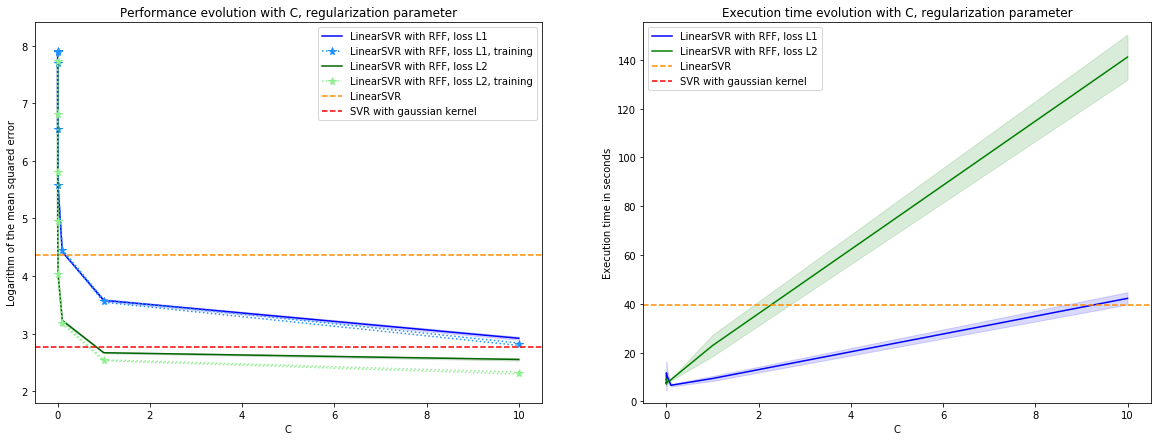

In [47]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

log_scores_rff_l1 = np.log(scores_rff_l1)
log_scores_train_rff_l1 = np.log(scores_train_rff_l1)
log_scores_rff_l2 = np.log(scores_rff_l2)
log_scores_train_rff_l2 = np.log(scores_train_rff_l2)

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(log_scores_rff_l1, axis=1) + np.std(log_scores_rff_l1, axis=1)),
            max(np.mean(log_scores_train_rff_l1, axis=1) + np.std(log_scores_train_rff_l1, axis=1)),
            max(np.mean(log_scores_rff_l2, axis=1) + np.std(log_scores_rff_l2, axis=1)),
            max(np.mean(log_scores_train_rff_l2, axis=1) + np.std(log_scores_train_rff_l2, axis=1)),
            np.log(score_lin), np.log(score_gauss))+0.5
y_min = min(min(np.mean(log_scores_rff_l1, axis=1) - np.std(log_scores_rff_l1, axis=1)),
            min(np.mean(log_scores_train_rff_l1, axis=1) - np.std(log_scores_train_rff_l1, axis=1)),
            min(np.mean(log_scores_rff_l2, axis=1) - np.std(log_scores_rff_l2, axis=1)),
            min(np.mean(log_scores_train_rff_l2, axis=1) - np.std(log_scores_train_rff_l2, axis=1)),
            np.log(score_lin), np.log(score_gauss))-0.5

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(log_scores_rff_l1, axis=1), '-', color='blue', label='LinearSVR with RFF, loss L1')
ax1.fill_between(list_C, np.mean(log_scores_rff_l1, axis=1) - np.std(log_scores_rff_l1, axis=1),
                 np.mean(log_scores_rff_l1, axis=1) + np.std(log_scores_rff_l1, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(log_scores_train_rff_l1, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with RFF, loss L1, training')
ax1.plot(list_C, np.mean(log_scores_train_rff_l1, axis=1) - np.std(log_scores_train_rff_l1, axis=1), ':',color='dodgerblue')
ax1.plot(list_C, np.mean(log_scores_train_rff_l1, axis=1) + np.std(log_scores_train_rff_l1, axis=1), ':',color='dodgerblue')

ax1.plot(list_C, np.mean(log_scores_rff_l2, axis=1), '-', color='darkgreen', label='LinearSVR with RFF, loss L2')
ax1.fill_between(list_C, np.mean(log_scores_rff_l2, axis=1) - np.std(log_scores_rff_l2, axis=1),
                 np.mean(log_scores_rff_l2, axis=1) + np.std(log_scores_rff_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(log_scores_train_rff_l2, axis=1), '*', markersize=8, color='lightgreen',
         label='LinearSVR with RFF, loss L2, training')
ax1.plot(list_C, np.mean(log_scores_train_rff_l2, axis=1) - np.std(log_scores_train_rff_l2, axis=1), ':',color='lightgreen')
ax1.plot(list_C, np.mean(log_scores_train_rff_l2, axis=1) + np.std(log_scores_train_rff_l2, axis=1), ':',color='lightgreen')

ax1.axhline(y=np.log(score_lin), color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=np.log(score_gauss), color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Logarithm of the mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_rff_l1, axis=1) + np.std(times_rff_l1, axis=1)),
            max(np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_rff_l1, axis=1) - np.std(times_rff_l1, axis=1)),
            min(np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_rff_l1, axis=1), '-', color='blue', label='LinearSVR with RFF, loss L1')
ax2.fill_between(list_C, np.mean(times_rff_l1, axis=1) - np.std(times_rff_l1, axis=1),
                 np.mean(times_rff_l1, axis=1) + np.std(times_rff_l1, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_rff_l2, axis=1), '-', color='green', label='LinearSVR with RFF, loss L2')
ax2.fill_between(list_C, np.mean(times_rff_l2, axis=1) - np.std(times_rff_l2, axis=1),
                 np.mean(times_rff_l2, axis=1) + np.std(times_rff_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_log_CT.png")
plt.show()

In [18]:
print("SVR with gaussian kernel execution time:", time_gauss)

SVR with gaussian kernel execution time: 1274.2267017364502
